<a href="https://colab.research.google.com/github/david-meltzer/LLMs/blob/main/data_analysis/wiki_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies



In [5]:
%cd drive/MyDrive/LLMs/wikipedia

[Errno 2] No such file or directory: 'drive/MyDrive/LLMs/wikipedia'
/content/drive/MyDrive/LLMs/wikipedia


In [10]:
!pip install datasets
!pip install textstat
!pip install wandb
!pip install -U sentence-transformers

!pip install apache-beam
!pip install transformers[torch] evaluate
!pip install mwparserfromhell
!pip install openai
!pip install wandb


  Using cached dill-0.3.1.1-py3-none-any.whl
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.15 requires dill>=0.3.7, but you have dill 0.3.1.1 which is incompatible.


  Using cached dill-0.3.7-py3-none-any.whl (115 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.49.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.2 MB/s eta 0:00:00


In [11]:
from datasets import load_dataset, load_from_disk
from sentence_transformers import SentenceTransformer
from textstat import flesch_reading_ease as fre
from textstat import flesch_kincaid_grade as fkg
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


import os
import openai
import json
from getpass import getpass

from scipy.stats import kstest
import numpy as np
import wandb
import datetime
from datetime import datetime

wandb.login()

%matplotlib inline

# Definitions

In [9]:
def flesch_scores(example):
    """
    Calculate Flesch Readability scores for each article
    """

    example['fre'] = fre(example['text'])
    example['fkg'] = fkg(example['text'])
    return example

def extract_article_text(example):
    """
    Extracts the text from a Wikipedia article before the "Related pages" and "References" sections.

    Parameters:
        example (dict): Dictionary with key 'text' which contains entire Wikipedia article content as a string.

    Returns:
        str: The article text before the "Related pages" and "References" sections.
    """
    text = example['text']

    # Find the positions of the "Related pages" and "References" sections
    txt_lower = text.lower()

    related_pages_position = txt_lower.find('related pages')
    references_position = txt_lower.find('references')

    # Extract the text before the sections
    article_text = ""
    if related_pages_position != -1:
        # If the "Related pages" section is found, extract the text before it
        article_text = text[:related_pages_position]
    elif references_position != -1:
        # If the "References" section is found (but not the "Related pages" section),
        # extract the text before it
        article_text = text[:references_position]
    else:
        # If both sections are not present, return the entire text
        article_text = text

    # Remove leading and trailing whitespace from the extracted text
    article_text = article_text.strip()

    example['text'] = ' '.join(article_text.split())

    return example

def remove_sections(article):

    article_split = article.split('\n')
    article_split = [txt for txt in article_split if len(txt.split())>=5]

    return '\n'.join(article_split)

def trunc_article(text):
    text = text.split('\n')
    new_txt = text[0]
    i=1

    while len(new_txt)<=512 and i<len(text):
        new_txt += ' '+text[i]
        i += 1

    new_txt = ' '.join(new_txt.split())

    return new_txt.strip()

def system_message(message,extra=None):
    if extra is None:
        message = 'You are a helpful assistant that generates instructions from text.'
    else:
        message = f'You are a helpful assistant that generates instructions from text. {extra}'

def create_prompt(text,extra=None):
    if extra is None:
        prompt = f"Instruction: X\nOutput: {text}\nWhat kind of instruction, X, could this be an answer to?\nX:"
    else:
        prompt = f"Instruction: X\nOutput: {text}\nWhat kind of instruction, X, could this be an answer to? {extra}\nX:"

    return prompt

# Comparing Readability

## Filter datasets

In [ ]:
english_wiki = load_dataset("wikipedia", "20220301.en")
simple_wiki = load_dataset("wikipedia", "20220301.simple")

In [ ]:
english_wiki.save_to_disk('./data/english_wiki')

Saving the dataset (0/41 shards):   0%|          | 0/6458670 [00:00<?, ? examples/s]

In [ ]:
simple_wiki_title = simple_wiki['train']['title']
shared_titles = set(simple_wiki_title).intersection(set(english_wiki['train']['title']))
diff_titles = set(english_wiki['train']['title']).union(set(simple_wiki_title))
diff_titles = diff_titles - set(english_wiki['train']['title']).intersection(set(simple_wiki_title))
only_in_simple = set(simple_wiki_title)-set(simple_wiki_title).intersection(set(english_wiki['train']['title']))

In [ ]:
english_wiki_shared = english_wiki.filter(
    lambda post: post['title'] in shared_titles
)

Filter:   0%|          | 0/6458670 [00:00<?, ? examples/s]

In [ ]:
simple_wiki_shared = simple_wiki.filter(
    lambda post: post['title'] in shared_titles
)

Filter:   0%|          | 0/205328 [00:00<?, ? examples/s]

In [ ]:
english_wiki_shared['train'] = english_wiki_shared['train'].map(extract_article_text)
simple_wiki_shared['train'] = simple_wiki_shared['train'].map(extract_article_text)

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [ ]:
english_wiki_shared['train'] = english_wiki_shared['train'].map(flesch_scores)
simple_wiki_shared['train'] = simple_wiki_shared['train'].map(flesch_scores)

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [ ]:
simple_wiki_shared.save_to_disk('./data/simple_wiki_shared')
english_wiki_shared.save_to_disk('./data/english_wiki_shared')

Saving the dataset (0/1 shards):   0%|          | 0/179814 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/179814 [00:00<?, ? examples/s]

## Figures

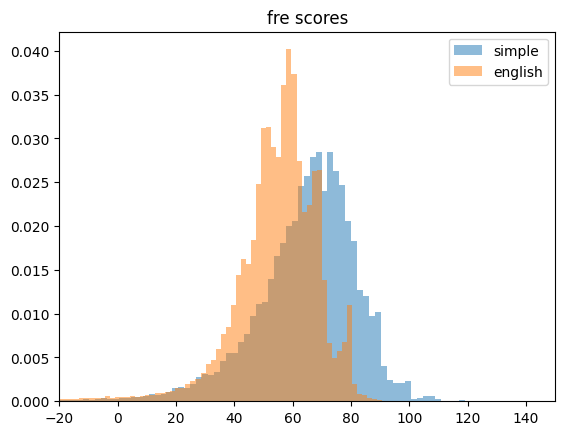

In [ ]:
fig, ax = plt.subplots()

ax.hist(simple_wiki_shared['train']['fre'],
         bins=2000,
         density=True,
         alpha=.5,
         label='simple')
ax.hist(english_wiki_shared['train']['fre'],
         bins=2000,
         density=True,
         alpha=.5,
         label='english')

ax.set_xlim(-20,150)
plt.title('fre scores')
plt.legend(loc='upper right')
plt.savefig('./figures/wiki_fre')
plt.show()

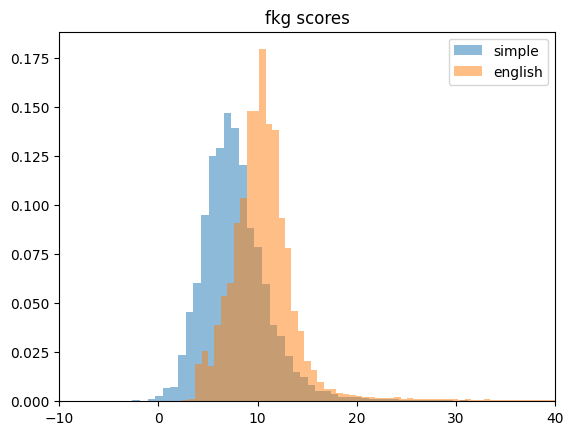

In [ ]:
fig, ax = plt.subplots()

ax.hist(simple_wiki_shared['train']['fkg'],
         bins=2000,
         density=True,
         alpha=.5,
         label='simple')
ax.hist(english_wiki_shared['train']['fkg'],
         bins=2000,
         density=True,
         alpha=.5,
         label='english')

ax.set_xlim(-10,40)
plt.title('fkg scores')
plt.legend(loc='upper right')
plt.savefig('./figures/wiki_fkg')
plt.show()

In [ ]:
fkg_scores = {}
fkg_scores['simple'] = simple_wiki_shared['train']['fkg']
fkg_scores['english'] = english_wiki_shared['train']['fkg']

fre_scores = {}
fre_scores['simple'] = simple_wiki_shared['train']['fre']
fre_scores['english'] = english_wiki_shared['train']['fre']

In [ ]:
kstest(np.array(fkg_scores['english']),np.array(fkg_scores['simple']))

KstestResult(statistic=0.42008408688978616, pvalue=0.0, statistic_location=8.5, statistic_sign=-1)

In [ ]:
kstest(np.array(fre_scores['english']),np.array(fre_scores['simple']))

KstestResult(statistic=0.34224810081528695, pvalue=0.0, statistic_location=63.32, statistic_sign=1)

# Make Simple Wiki Simple Again

In [ ]:
simple_wiki = load_dataset("wikipedia", "20220301.simple")

simple_wiki = simple_wiki.map(extract_article_text)
simple_wiki_scored = simple_wiki.map(flesch_scores)

In [ ]:
simple_wiki_filt = simple_wiki_scored.filter(lambda article: article['fre']>=60 and article['fkg']<9)

In [ ]:
(sum(len(simple_wiki_filt[key]) for key in simple_wiki_filt))/len(simple_wiki_scored['train'])

0.6139104262448375

In [ ]:
simple_wiki_split_tmp = simple_wiki_filt['train'].train_test_split(test_size=5000,seed=42)

In [ ]:
simple_wiki_split = simple_wiki_split_tmp['train'].train_test_split(test_size=5000,seed=42)

simple_wiki_split['validation'] = simple_wiki_split_tmp['test']

In [ ]:
simple_wiki_split.save_to_disk('./data/simple_wiki_split')

Saving the dataset (0/1 shards):   0%|          | 0/116053 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
now = datetime.now()
file_name = './data/simple_wiki_split'
time_stamp = now.strftime("%m.%d.%y-%H.%M.%S")
with wandb.init(project='ELI5_analysis',
                            entity='ft-llmmm',
                            job_type='log_data',
                            name=f'log_wiki_data_{time_stamp}') as run:
                # Initialize a WandB run for logging
                data_art = wandb.Artifact('simple_wiki_split', 'dataset')
                data_art.add_dir(file_name)
                run.log_artifact(data_art)

wandb: Currently logged in as: dmeltzer (ft-llmmm). Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (./data/simple_wiki_split)... Done. 1.3s


# Prompts

In [15]:
openai.api_key = getpass('Enter your OpenAI key: ')

model_engine = 'gpt-3.5-turbo'

def create_message(extra=None):
    if extra != '':
        extra = ' '+extra
    message=f'You are a helpful assistant that generates instructions from text.{extra}'

def create_prompt(text,
                  extra):

    if extra !='':
        extra = ' '+extra
    prompt = f"Instruction: X\nOutput: {text}\nWhat kind of instruction, X, could this be an answer to?{extra}\nX:."
    return prompt

Enter your OpenAI key: ··········


In [14]:
message_extra = []
message_extra.append('')
message_extra.append('You write text using Simple English.')
message_extra.append('You write text that is simple, concise, and easy to understand.')
message_extra.append('You write text using the style of ELI5.')


prompt_extra = []
prompt_extra.append('')
prompt_extra.append('Write the instruction using Simple English.')
prompt_extra.append('Write an instruction which is simple, concise, and easy to understand.')
prompt_extra.append('Write an instruction in the style of ELI5.')

In [ ]:
def GPT_instructions(text,
                     message_extra='',
                     prompt_extra=''):

    system_message = create_message(message_extra)
    prompt = create_prompt(text, prompt_extra)

    response=openai.ChatCompletion.create(
        model=model_engine,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt},
        ],
        temperature = 0)

    instruction = response['choices'][0]['message']['content']

    return instruction



# Scratch